In [64]:
# CVA Credit Value Adjustment example  using Merton model of firm valuation and default of Debt
# Credit Value Adjustment takes into account counterparty risk/default risk e.g OTC tradeds in options etc
# Largely developed from Exposure E(t) = max(V(t),0) what you stand to lose at time t based on value of your portfolio
# CVA measures the market value of the counterparty credit risk
# When using the Merton model we use similar assumptions as Black Scholes serve of that of risk ofno default
# Maximum amount firm can pay towards debt can be considered as a put optionon value of firm with strike price Debt value 
# Mostly assume default by counterparty happens at expiry T of contract
# Assets normally simulated using normal distribution
# We can consider or ignore correlations between firm value and value of protfolio 

In [65]:
# import modules
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random
np.random.seed(0)

In [66]:
# Market information for our example 
# Suppose you hold a call option with info below
S_0   = 100 # Initial stock price
sigma_asset = 0.3 # volatility stock price
r     = 0.1 # continouslu compounded risk free interest rate
K     = 110 # Strike price of call option
T     = 1   # Time to maturity

# Counterparty to your call option dynamics
V_0   = 200  # current valuation of firm
sigma_firm = 0.25 # volatility of valuation of firm
D     = 180  # Debt of the company  owned in one year 
r_r   = 0.2  # recovery rate fraction of what you owed that you can receive in case of default
T     = 1

In [67]:
# Functions for valuations
def terminal_value(S_0,r,sigma,Z,T):
    """"
    Takes the initial asset/stock price in portfolio, risk free rate, volatilty of stock/asset, Z-normal distributed
    random variables, T-time to maturity and returns potential terminal value/value asset stock at time T
    Used to model terminal value of stock and firm value
    """
    return S_0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)

def call_pay_off(S_T,K):
    """
    takes the potential terminal value(s) at time T and strike price and returns payoff at time T
    """
    return np.maximum(S_T-K,0)

In [68]:
# Create an array of values between -1,1 to test various correlations between firm and portfolio value
# We will generate various CVA values for different correlation dynamics
corr_tested   = np.linspace(-1,1,21)
cva_estimates = [None]*len(corr_tested)
cva_std       = [None]*len(corr_tested)

In [70]:
# Running Monte Carlo estimation using 50,000 sample size for both firm value and stock prices
# Take into account when there is correlation is not 1 and -1 we applycholesky decomposition to corr_matrix

for i in range(len(corr_tested)):
    
    correlation = corr_tested[i]
    
    if (correlation == 1 or correlation == -1):
        norm_vec_0  = norm.rvs(size = 50000)
        norm_vec_1  = correlation*norm_vec_0
        corr_matrix = np.array([norm_vec_0,norm_vec_1])
        
    else:
        corr_matrix = np.array([[1,correlation],[correlation,1]])
        norm_matrix = norm.rvs(size = np.array([2,50000]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix),norm_matrix)
    
    terminal_asset_value = terminal_value(S_0,r,sigma_asset,corr_norm_matrix[0,],T)
    terminal_firm_value  = terminal_value(V_0,r,sigma_firm,corr_norm_matrix[1,],T)
    call_value_asset     = call_pay_off(terminal_asset_value,K)
    amount_lost          = np.exp(-r*T)*(1-r_r)*(terminal_firm_value<D)*call_value_asset
    
    cva_estimates[i]     = np.mean(amount_lost)
    cva_std[i]           = np.std(amount_lost)/np.sqrt(50000)

In [74]:
# Calculation of CVA assuming zero correlation between asset/portfolio value and firm value
# For above case we make use of (1-recovery_rate)*Call_Price*norm.cdf(-d2) ..(1-r_r)*Xo*norm.cdf(-d_2)
# norm.cdf(-d_2) if the probability of debt default by firm to give [(1-r_r)*Call_Price*default_probability]

d_1 = (np.log(V_0/D) + (r+sigma_firm**2/2)*T)/sigma_firm*np.sqrt(T)
d_2 = d_1 - sigma_firm*np.sqrt(T)
default_probability = norm.cdf(-d_2)

# Analytic solution for European Call Option
d_1_stock = (np.log(S_0/K) + (r+sigma_asset**2/2)*T)/sigma_asset*np.sqrt(T)
d_2_stock = d_1_stock - sigma_asset*np.sqrt(T)

analytic_call_price = S_0*norm.cdf(d_1_stock) - K*np.exp(-r*T)*norm.cdf(d_2_stock)

# Calculate uncorrelated CVA using above inputs
uncorr_CVA  = (1-r_r)*analytic_call_price*default_probability

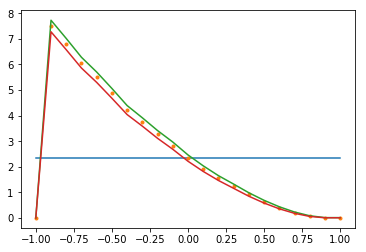

In [79]:
# Plot CVA values at different correlation levels
plt.plot(corr_tested,[uncorr_CVA]*21)
plt.plot(corr_tested,cva_estimates,'.')
plt.plot(corr_tested,cva_estimates + 3* np.array(cva_std))
plt.plot(corr_tested,cva_estimates - 3* np.array(cva_std))
plt.show()